# Developing an efficient algorithm for the Storkey Learning Rule

In [1]:
import numbers
import numpy as np
import imageio
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

np.random.seed(2)

In [2]:
nunits = 4
npats = 2
pats = 2 * np.random.binomial(1, 0.5, [npats, nunits, nunits]) - 1
pats

array([[[-1, -1,  1, -1],
        [-1, -1, -1,  1],
        [-1, -1,  1,  1],
        [-1,  1, -1,  1]],

       [[ 1, -1,  1, -1],
        [ 1, -1, -1, -1],
        [-1,  1, -1, -1],
        [-1, -1, -1, -1]]])

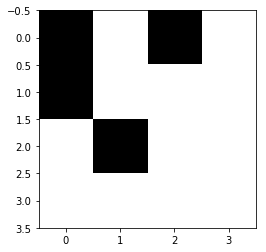

In [3]:
test_pat = pats[1]

plt.imshow(test_pat, cmap='Greys', interpolation='nearest')
plt.show()

Now train the weights. **Whereas before we used Hebb's rule, now let's use the Storkey Learning Rule**. This rule has a few nice advantages over Hebb's rule: it allows the network to learn more patterns, its basins of attraction (to the stored patterns) are larger, the distribution of basin sizes is more even, and the shapes of the basins are more round. The weights at time `v` are:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e0b194a405a470e54aacef9e75ced89d02f60844)

where
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/c0e9c85f5bbf569acdfc8dd7ab8cccb742a0f856)

and `n` is the number of neurons and $\epsilon$ is a bit (+1 or -1) of pattern `v`.

The second term of the rule is basically the Hebbian rule. The third and fourth terms basically account for the net input to neurons j and i using the current weights.

Here is the algorithm I settled on.

In [4]:
def storkey_rule(pattern, old_weights=None):
    """
    pattern: 2-dimensional array
    old_weights: square array of length pattern.shape[0]*pattern.shape[1]
    """
    
    mem = pattern.flatten()    
    n = len(mem)
    
    if old_weights is None:
        old_weights = np.zeros(shape=(n,n))

    hebbian_term  = np.outer(mem,mem)
    
    net_inputs = old_weights.dot(mem)
    net_inputs = np.tile(net_inputs, (n, 1)) # repeat the net_input vector n times along the rows 
                                             # so we now have a matrix
    
    # h_i and h_j should exclude input from i and j from h_ij
    h_i = np.diagonal(old_weights) * mem # this obtains the input each neuron receives from itself
    h_i = h_i[:, np.newaxis]             # turn h_i into a column vector so we can subtract from hij appropriately
    
    h_j = old_weights * mem              # element-wise multiply each row of old-weights by mem    
    np.fill_diagonal(h_j,0)              # now replace the diagonal of h_j with 0's; the diagonal of h_j is the 
                                         # self-inputs, which are redundant with h_i
    
    hij = net_inputs - h_i - h_j
    
    post_synaptic  = hij * mem
    #pre_synaptic = post_synaptic.T
        
    #new_weights = old_weights + (1./n)*(hebbian_term - pre_synaptic - post_synaptic)
    new_weights = old_weights + (1./n)*(hebbian_term - 2*post_synaptic)
    
    return new_weights

That algorithm is probably fairly opaque, owing to the matrix operations in it. Let's unpack it step-by-step. It's most illustrative to look at what happens when you are training a second pattern, because the weights of the first pattern are simply due to the hebbian term -- the other terms are just 0's. So, we'll start with `old_weights` from training the first test pattern.

In [5]:
old_weights = storkey_rule(pats[0])

pattern = pats[1]

mem = pattern.flatten()
print(mem)

[ 1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1]


In [6]:
n = len(mem)
print(n)

16


In [7]:
if old_weights is None:
    old_weights = np.zeros(shape=(n,n))

hebbian_term  = np.outer(mem,mem)
print(hebbian_term)

[[ 1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]
 [-1  1 -1  1 -1  1  1  1  1 -1  1  1  1  1  1  1]]


In [8]:
net_inputs = old_weights.dot(mem)
print(net_inputs)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [9]:
net_inputs = np.tile(net_inputs, (n, 1)) # repeat the net_input vector n times along the rows 
                                         # so we now have a matrix
print(net_inputs)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [10]:
# h_i and h_j should exclude input from i and j from h_ij
h_i = np.diagonal(old_weights) * mem # this obtains the input each neuron receives from itself
h_i = h_i[:, np.newaxis]             # turn h_i into a column vector so we can subtract from hij appropriately
print(h_i)

[[ 0.0625]
 [-0.0625]
 [ 0.0625]
 [-0.0625]
 [ 0.0625]
 [-0.0625]
 [-0.0625]
 [-0.0625]
 [-0.0625]
 [ 0.0625]
 [-0.0625]
 [-0.0625]
 [-0.0625]
 [-0.0625]
 [-0.0625]
 [-0.0625]]


In [11]:
h_j = old_weights * mem              # element-wise multiply each row of old-weights by mem
np.fill_diagonal(h_j,0)
print(h_j)

[[ 0.     -0.0625 -0.0625 -0.0625  0.0625 -0.0625 -0.0625  0.0625 -0.0625
   0.0625  0.0625  0.0625 -0.0625  0.0625 -0.0625  0.0625]
 [ 0.0625  0.     -0.0625 -0.0625  0.0625 -0.0625 -0.0625  0.0625 -0.0625
   0.0625  0.0625  0.0625 -0.0625  0.0625 -0.0625  0.0625]
 [-0.0625  0.0625  0.      0.0625 -0.0625  0.0625  0.0625 -0.0625  0.0625
  -0.0625 -0.0625 -0.0625  0.0625 -0.0625  0.0625 -0.0625]
 [ 0.0625 -0.0625 -0.0625  0.      0.0625 -0.0625 -0.0625  0.0625 -0.0625
   0.0625  0.0625  0.0625 -0.0625  0.0625 -0.0625  0.0625]
 [ 0.0625 -0.0625 -0.0625 -0.0625  0.     -0.0625 -0.0625  0.0625 -0.0625
   0.0625  0.0625  0.0625 -0.0625  0.0625 -0.0625  0.0625]
 [ 0.0625 -0.0625 -0.0625 -0.0625  0.0625  0.     -0.0625  0.0625 -0.0625
   0.0625  0.0625  0.0625 -0.0625  0.0625 -0.0625  0.0625]
 [ 0.0625 -0.0625 -0.0625 -0.0625  0.0625 -0.0625  0.      0.0625 -0.0625
   0.0625  0.0625  0.0625 -0.0625  0.0625 -0.0625  0.0625]
 [-0.0625  0.0625  0.0625  0.0625 -0.0625  0.0625  0.0625  0.      0.

In [12]:
hij = net_inputs - h_i - h_j
print(hij)

[[-0.0625  0.      0.      0.     -0.125   0.      0.     -0.125   0.
  -0.125  -0.125  -0.125   0.     -0.125   0.     -0.125 ]
 [ 0.      0.0625  0.125   0.125   0.      0.125   0.125   0.      0.125
   0.      0.      0.      0.125   0.      0.125   0.    ]
 [ 0.     -0.125  -0.0625 -0.125   0.     -0.125  -0.125   0.     -0.125
   0.      0.      0.     -0.125   0.     -0.125   0.    ]
 [ 0.      0.125   0.125   0.0625  0.      0.125   0.125   0.      0.125
   0.      0.      0.      0.125   0.      0.125   0.    ]
 [-0.125   0.      0.      0.     -0.0625  0.      0.     -0.125   0.
  -0.125  -0.125  -0.125   0.     -0.125   0.     -0.125 ]
 [ 0.      0.125   0.125   0.125   0.      0.0625  0.125   0.      0.125
   0.      0.      0.      0.125   0.      0.125   0.    ]
 [ 0.      0.125   0.125   0.125   0.      0.125   0.0625  0.      0.125
   0.      0.      0.      0.125   0.      0.125   0.    ]
 [ 0.125   0.      0.      0.      0.125   0.      0.      0.0625  0.
   0.125   0

In [13]:
post_synaptic  = hij * mem
print(post_synaptic)

[[-0.0625 -0.      0.     -0.     -0.125  -0.     -0.      0.125  -0.
  -0.125   0.125   0.125  -0.      0.125  -0.      0.125 ]
 [ 0.     -0.0625  0.125  -0.125   0.     -0.125  -0.125  -0.     -0.125
   0.     -0.     -0.     -0.125  -0.     -0.125  -0.    ]
 [ 0.      0.125  -0.0625  0.125   0.      0.125   0.125  -0.      0.125
   0.     -0.     -0.      0.125  -0.      0.125  -0.    ]
 [ 0.     -0.125   0.125  -0.0625  0.     -0.125  -0.125  -0.     -0.125
   0.     -0.     -0.     -0.125  -0.     -0.125  -0.    ]
 [-0.125  -0.      0.     -0.     -0.0625 -0.     -0.      0.125  -0.
  -0.125   0.125   0.125  -0.      0.125  -0.      0.125 ]
 [ 0.     -0.125   0.125  -0.125   0.     -0.0625 -0.125  -0.     -0.125
   0.     -0.     -0.     -0.125  -0.     -0.125  -0.    ]
 [ 0.     -0.125   0.125  -0.125   0.     -0.125  -0.0625 -0.     -0.125
   0.     -0.     -0.     -0.125  -0.     -0.125  -0.    ]
 [ 0.125  -0.      0.     -0.      0.125  -0.     -0.     -0.0625 -0.
   0.125  -0

In [14]:
pre_synaptic = post_synaptic.T #equivalent to np.outer(hij,mem)
print(pre_synaptic)

[[-0.0625  0.      0.      0.     -0.125   0.      0.      0.125   0.
  -0.125   0.125   0.125   0.      0.125   0.      0.125 ]
 [-0.     -0.0625  0.125  -0.125  -0.     -0.125  -0.125  -0.     -0.125
  -0.     -0.     -0.     -0.125  -0.     -0.125  -0.    ]
 [ 0.      0.125  -0.0625  0.125   0.      0.125   0.125   0.      0.125
   0.      0.      0.      0.125   0.      0.125   0.    ]
 [-0.     -0.125   0.125  -0.0625 -0.     -0.125  -0.125  -0.     -0.125
  -0.     -0.     -0.     -0.125  -0.     -0.125  -0.    ]
 [-0.125   0.      0.      0.     -0.0625  0.      0.      0.125   0.
  -0.125   0.125   0.125   0.      0.125   0.      0.125 ]
 [-0.     -0.125   0.125  -0.125  -0.     -0.0625 -0.125  -0.     -0.125
  -0.     -0.     -0.     -0.125  -0.     -0.125  -0.    ]
 [-0.     -0.125   0.125  -0.125  -0.     -0.125  -0.0625 -0.     -0.125
  -0.     -0.     -0.     -0.125  -0.     -0.125  -0.    ]
 [ 0.125  -0.     -0.     -0.      0.125  -0.     -0.     -0.0625 -0.
   0.125  -0

In [15]:
new_weights = old_weights + (1./n)*(hebbian_term - pre_synaptic - post_synaptic)
print(new_weights)

[[ 0.1328125  0.         0.         0.         0.140625   0.         0.
  -0.140625   0.         0.140625  -0.140625  -0.140625   0.        -0.140625
   0.        -0.140625 ]
 [ 0.         0.1328125 -0.140625   0.140625   0.         0.140625
   0.140625   0.         0.140625   0.         0.         0.         0.140625
   0.         0.140625   0.       ]
 [ 0.        -0.140625   0.1328125 -0.140625   0.        -0.140625
  -0.140625   0.        -0.140625   0.         0.         0.        -0.140625
   0.        -0.140625   0.       ]
 [ 0.         0.140625  -0.140625   0.1328125  0.         0.140625
   0.140625   0.         0.140625   0.         0.         0.         0.140625
   0.         0.140625   0.       ]
 [ 0.140625   0.         0.         0.         0.1328125  0.         0.
  -0.140625   0.         0.140625  -0.140625  -0.140625   0.        -0.140625
   0.        -0.140625 ]
 [ 0.         0.140625  -0.140625   0.140625   0.         0.1328125
   0.140625   0.         0.140625   0. 

Now, let's verify that that algorithms works (I'm kinda shaky on my linear algebra). Let's verify it against an inefficient, but more transparent, for-loops implementation...

Again, the formula for the Storkey rule:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e0b194a405a470e54aacef9e75ced89d02f60844)

where
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/c0e9c85f5bbf569acdfc8dd7ab8cccb742a0f856)

In [16]:
def storkey_rule_loops(patterns):
    memories = [x.flatten() for x in patterns]
    neurons  = len(memories[0])
    memMat = np.zeros((neurons,neurons))
    for mem in memories:
        oldMemMat = memMat.copy()
        for i in range(neurons):
            for j in range(neurons):
                hij = np.sum([ oldMemMat[i,k]*mem[k] for k in range(neurons) if k not in [i,j] ])
                hji = np.sum([ oldMemMat[j,k]*mem[k] for k in range(neurons) if k not in [i,j] ])
                memMat[i,j] += (1./neurons)*(mem[i]*mem[j] - mem[i]*hji - mem[j]*hij)
    return memMat

In [17]:
%timeit storkey_rule(pattern=pats[1], old_weights=storkey_rule(pats[0]) )

The slowest run took 15.24 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 134 µs per loop


In [18]:
%timeit storkey_rule_loops(pats)

10 loops, best of 3: 32 ms per loop


As expected, the matrix math version -- which uses the optimized numpy data structures and operations -- is much, much faster than the for-loops verison. Now compare the weights of the two approaches.

In [19]:
loop_weights = storkey_rule_loops(pats)
print(loop_weights)

[[ 0.1328125  0.         0.         0.         0.140625   0.         0.
  -0.140625   0.         0.140625  -0.140625  -0.140625   0.        -0.140625
   0.        -0.140625 ]
 [ 0.         0.1328125 -0.140625   0.140625   0.         0.140625
   0.140625   0.         0.140625   0.         0.         0.         0.140625
   0.         0.140625   0.       ]
 [ 0.        -0.140625   0.1328125 -0.140625   0.        -0.140625
  -0.140625   0.        -0.140625   0.         0.         0.        -0.140625
   0.        -0.140625   0.       ]
 [ 0.         0.140625  -0.140625   0.1328125  0.         0.140625
   0.140625   0.         0.140625   0.         0.         0.         0.140625
   0.         0.140625   0.       ]
 [ 0.140625   0.         0.         0.         0.1328125  0.         0.
  -0.140625   0.         0.140625  -0.140625  -0.140625   0.        -0.140625
   0.        -0.140625 ]
 [ 0.         0.140625  -0.140625   0.140625   0.         0.1328125
   0.140625   0.         0.140625   0. 

In [20]:
matrix_weights = storkey_rule(pats[1], old_weights=storkey_rule(pats[0]))
print(matrix_weights)

[[ 0.1328125  0.         0.         0.         0.140625   0.         0.
  -0.140625   0.         0.140625  -0.140625  -0.140625   0.        -0.140625
   0.        -0.140625 ]
 [ 0.         0.1328125 -0.140625   0.140625   0.         0.140625
   0.140625   0.         0.140625   0.         0.         0.         0.140625
   0.         0.140625   0.       ]
 [ 0.        -0.140625   0.1328125 -0.140625   0.        -0.140625
  -0.140625   0.        -0.140625   0.         0.         0.        -0.140625
   0.        -0.140625   0.       ]
 [ 0.         0.140625  -0.140625   0.1328125  0.         0.140625
   0.140625   0.         0.140625   0.         0.         0.         0.140625
   0.         0.140625   0.       ]
 [ 0.140625   0.         0.         0.         0.1328125  0.         0.
  -0.140625   0.         0.140625  -0.140625  -0.140625   0.        -0.140625
   0.        -0.140625 ]
 [ 0.         0.140625  -0.140625   0.140625   0.         0.1328125
   0.140625   0.         0.140625   0. 

In [27]:
np.all(matrix_weights == loop_weights)

True

And indeed, they are the same!

Now let's show that the weights work, i.e., that feeding the network a noisy version of a trained pattern recovers the trained pattern itself. We'll just flip a certain number of random pixels on each row of the trained pattern.

In [22]:
def noisify(pattern, numb_flipped):

    noisy_pattern = pattern.copy()

    for idx, row in enumerate(noisy_pattern):
        choices = np.random.choice(range(len(row)), numb_flipped)
        noisy_pattern[idx,choices] = -noisy_pattern[idx,choices]
        
    return noisy_pattern

noisy_test_pat = noisify(pattern=test_pat, numb_flipped=1)

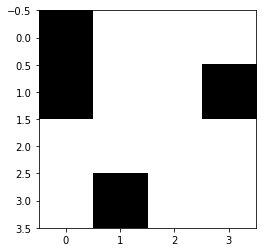

In [23]:
plt.imshow(noisy_test_pat, cmap='Greys', interpolation='nearest')
plt.show()

Now we can start with that, and use the weights to update it. We'll update the units asynchronously (one at a time), and keep track of the energy of the network every so often.

In [24]:
def flow(pattern, weights, theta=0, steps = 1000):
    
    pattern_flat = pattern.flatten()

    if isinstance(theta, numbers.Number):
        thetas = np.zeros(len(pattern_flat)) + theta
    
    for step in range(steps):
        unit = np.random.randint(low=0, high=(len(pattern_flat)-1))
        unit_weights = weights[unit,:]
        net_input = np.dot(unit_weights,pattern_flat)
        pattern_flat[unit] = 1 if (net_input > thetas[unit]) else -1
        
        if (step % 200) == 0:
            energy = -0.5*np.dot(np.dot(pattern_flat.T,weights),pattern_flat) + np.dot(thetas,pattern_flat)
            print("Energy at step {:05d} is now {}".format(step,energy))

    evolved_pattern = np.reshape(a=pattern_flat, newshape=(pattern.shape[0],pattern.shape[1]))
    
    return evolved_pattern

Energy at step 00000 is now -2.75
Energy at step 00200 is now -8.9375
Energy at step 00400 is now -8.9375
Energy at step 00600 is now -8.9375
Energy at step 00800 is now -8.9375


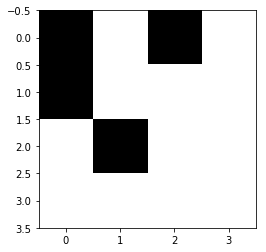

In [25]:
noisy_test_pat_evolved = flow(noisy_test_pat, matrix_weights)
plt.imshow(noisy_test_pat_evolved, cmap='Greys', interpolation='nearest')
plt.show()

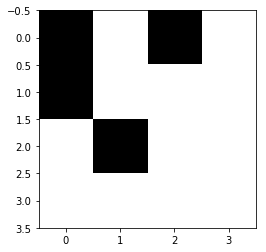

In [26]:
plt.imshow(test_pat, cmap='Greys', interpolation='nearest')
plt.show()

And lo, the network settles on the trained pattern.